# Convert to TFLite

Convert mobile to TFLite to be exported to other apps

## Config

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import json
from pprint import pprint

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

In [20]:
model_path = '../models/pipeline_v1/MNv3-xfer_multiclass_v1'
tflite_path = '../models/pipeline_v1/MNv3-xfer_multiclass.tflite'
model_labels_path = '../models/pipeline_v1/class_labels_multiclass.json'

sample_img_path = '../datasets/pipeline_v1/all_v1_multiclass/train/positive/poison_ivy_plant_1.jpg'
target_size = (224, 224)

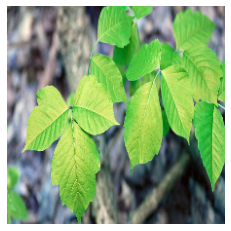

In [21]:
img = cv2.imread(sample_img_path)
img = cv2.resize(img, target_size)

plt.imshow(img)
plt.axis('off')
plt.show()

In [24]:
with open(model_labels_path, 'r') as f:
    class_names = json.load(f)
class_names

{'0': 'negative_general_plant',
 '1': 'negative_random_picture',
 '2': 'negative_similar_plant',
 '3': 'positive'}

## Convert Model

In [5]:
model = tf.keras.models.load_model(model_path)

In [6]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpykji6ua6/assets


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [9]:
tflite_path_obj = Path(tflite_path)
tflite_path_obj.write_bytes(tflite_model)

19458152

## Test Model

### Base Model

In [27]:
model_img = img.reshape((-1, *img.shape))
model_img.shape

(1, 224, 224, 3)

In [32]:
(base_probs,) = model.predict(model_img)
base_probs = {
    class_names[str(i)]: prob for i, prob in enumerate(base_probs)
}
pprint(base_probs)

{'negative_general_plant': 1.1350288e-07,
 'negative_random_picture': 7.1543975e-09,
 'negative_similar_plant': 0.013687598,
 'positive': 0.9863123}


### TFLite model

In [33]:
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

In [34]:
input_details = interpreter.get_input_details()
input_index = input_details[0]['index']
output_details = interpreter.get_output_details()
output_index = output_details[0]['index']


In [35]:
def get_prediction(img: np.ndarray, interpreter, input_index, output_index) -> np.ndarray:
    # Pass to tflite interpreter
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    return(interpreter.get_tensor(output_index))

In [42]:
input_dtype = input_details[0]['dtype']
tflite_img = np.array(model_img, dtype=input_dtype)
(tflite_probs,) = get_prediction(tflite_img, interpreter, input_index, output_index)
tflite_probs = {
    class_names[str(i)]: prob for i, prob in enumerate(tflite_probs)
}
pprint(tflite_probs)

{'negative_general_plant': 1.1350322e-07,
 'negative_random_picture': 7.1543433e-09,
 'negative_similar_plant': 0.013687448,
 'positive': 0.98631245}
